Tomás Mastantuono

LU: 522/23 <-> DNI: 45421427

# Librerias

Para mayor comodidad cargo todas las librerias que uso en este jupyter en la celda de abajo:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2, norm, uniform
import pandas as pd
from scipy.integrate import quad
from matplotlib.gridspec import GridSpec

# Introducción

En un principio del trabajo (primera hoja) me dan contexto sobre el objetivo del TP y sobre el modelo cosmológico $\Lambda CDM$ (Lambda Cold Dark Matter), el cual describe la evolución del universo, con la siguiente relación:

$$H(z) = H_{0} \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)}$$

Donde cada letra simboliza:

* $z$: Corrimiento al rojo
* $H(z)$: Tasa de expansión del universo a ese corrimiento al rojo
* $H_0$: Parámetro de Hubble

# Item 0

## Lectura de datos

In [4]:
datos = pd.read_csv('datos_cronometros.txt', sep = '\t')
z_datos, Hz_datos, err_Hz_datos = datos['z'], datos['H(z)'], datos['sigma_H(z)  ']

## Ajuste al modelo

En clase dijeron que no inventemos, asi que uso curvefit para realizar un ajuste sobre los datos con el modelo propuesto por la guia (es la que escribí en la introducción)

In [5]:
# Defino el modelo de ajuste
def H_modelo(z, H0, Omega_m): return H0 * ( Omega_m * (1 + z)**3 + (1 - Omega_m) )**(1/2)

# Obtengo los parámetros óptimos utilizando curve_fit
popt, pcov = curve_fit(H_modelo, z_datos, Hz_datos, sigma = err_Hz_datos)
H0_popt, Omega_m_popt = popt
err_H0_popt, err_Omega_m_popt = pcov[0][0]**(1/2), pcov[1][1]**(1/2)


## Grafico los datos observados

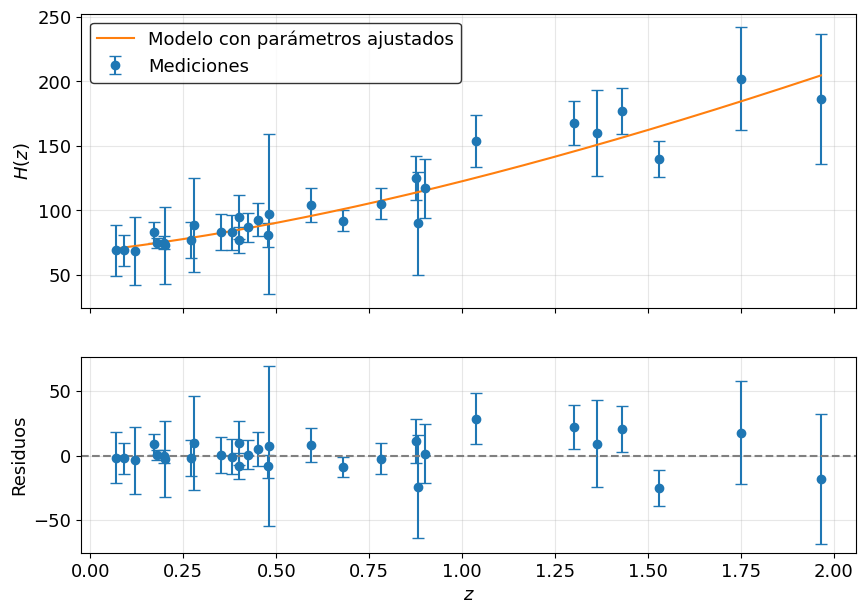

In [14]:
z_ajuste = np.linspace(min(z_datos), max(z_datos), 1_000)
fig = plt.figure(figsize = (10, 7))

gs = GridSpec(2, 1, height_ratios = [1.5, 1])

axs1 = fig.add_subplot(gs[1])
axs0 = fig.add_subplot(gs[0])

axs0.errorbar(z_datos, Hz_datos, yerr = err_Hz_datos, 
                fmt = 'o', capsize = 4, linestyle = 'None', label = 'Mediciones')
axs0.plot(z_ajuste, H_modelo(z_ajuste, H0_popt, Omega_m_popt), label = 'Modelo con parámetros ajustados')
axs0.set(ylabel = r'$H\left( z\right)$')
axs0.grid(alpha = 0.3)
axs0.legend(loc = 'upper left', edgecolor = 'black')
axs0.set_xticklabels([])


axs1.errorbar(z_datos, Hz_datos - H_modelo(z_datos, H0_popt, Omega_m_popt), yerr = err_Hz_datos, 
                fmt = 'o', linestyle = 'None', capsize = 4)
axs1.axhline(0, linestyle = '--', color = 'gray')
axs1.set(ylabel = 'Residuos', xlabel = r'$z$')
axs1.grid(alpha = 0.3)

plt.rcParams['font.size'] = 13
plt.savefig('imagenes/Problema_0.png')
plt.savefig('imagenes/Problema_0.pdf')
plt.show()

Muestro los resultados

In [66]:
print(H0_popt, err_H0_popt)
print(Omega_m_popt, err_Omega_m_popt)

68.14416703054454 2.2156112367621352
0.31964387420854734 0.042688123098015174


# Intervalo de confianza frecuentista

## Item 1

Acá sólo me piden que que tome $M$ valores de $H_0 / H_0 \in \left[60, 80 \right]$. Como no aclaran la forma en la que quieren que seleccionemos estos $M$ valores, directamente los saco de un linspace porque esto me va a ayudar cuando haga el último item.

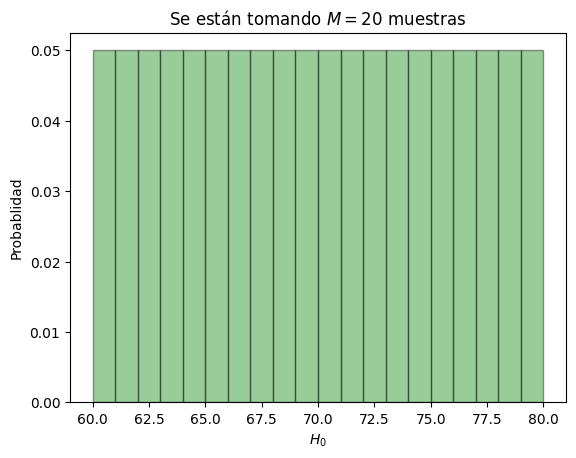

In [6]:
# Defino la cantidad de M que quiero
M = 20
H0s = np.linspace(60, 80, num = M)

# Verifico que devuelva algo uniforme en un rango [60, 80]
plt.figure()
plt.hist(H0s, bins = 20, density = True, color = 'green', alpha = 0.4, edgecolor = 'black')

plt.title(r'Se están tomando $M = $' + f'{M}' + ' muestras')
plt.ylabel('Probablidad')
plt.xlabel(r'$H_0$')

plt.savefig('imagenes/Item1.png')
plt.savefig('imagenes/Item1.pdf')
plt.show()

## Item 2

Basicamente me dicen que para cada $H_0$ simulado en el item anterior, me realice $N$ conjuntos de datos sintéticos utilizando las mediciones realizadas de cronómetros cósmicos, es decir $\left( z_i, \sigma_{H(x_i)} \right)$. Donde los datos sintéticos se deben generar de la siguiente forma:

$$H_i^{sint} = H_0 \sqrt{\Omega_m \left(1 + z_i \right)^3 + \left( 1 - \Omega_m \right)} + \epsilon_i$$

* $\epsilon_i \sim N\left( 0, \sigma_{H(z_i)} \right)$ : solo es un ruido gaussiano para que no den casi lo mismo que las mediciones.
* $\Omega_m = 0.3$ : esta información es dada al comienzo de la sección de Intervalo de confianza frecuentista, por lo que lo comienzo a utilizar.

La forma en la que programé/guardé los datos sintéticos fue de la siguiente forma:

* $H_{sin}$ : lista de python que almacena las $N$ simulaciones correspondientes a cada $H_0$ simulado, por lo que el largo de esta lista debe y es $M$.
* $H_i^{sin}$ : lista de python que almacena cada una de las $N$ simulaciones de $H_i$, por lo que su largo debe ser igual a $len \left( z_{datos} \right)$.

Tener en cuenta que además debo calcular el error de cada simulación agregada, esto se puede calcular si pienso en la forma que me dicen de realizar las $H_i^{sin}$, la cual está dada por:

$$H_i^{sin} = H_0 \sqrt{ \Omega_m \left( 1 + z_i \right)^3 + \left(1 - \Omega_m \right)} \equiv H_i + \epsilon_i$$

De esta forma se vuelve sencillo calcular su varianza, dado que, según lo que se puede interpretar por los datos que dan sobre $z_i$, estas no tienen error y $\Omega_m$ tampoco es una variable aleatoria ya que deciden que la fijemos en $0.3$. Abusando de esto se vuelve muy sencillo calcular la varianza:

$$Var\left(H_i^{sin} \right) = Var\left( \epsilon_i \right) = \sigma_{H\left( z_i \right)}^2$$

In [7]:
# Fijo el valor de Omega_m:
Omega_dato = 0.3

# Array donde guardo los datos sintéticos
H_sin = []
err_H_sin = []

N = 2_000 # número de datos sintéticos para cada H0
for H0_sin in H0s:
    Hi_sin, err_Hi_sin = [], []
    
    for _ in range(N):
        epsilo_i = norm(loc = 0, scale = err_Hz_datos).rvs(size = len(z_datos))
        Hi_sin.append(H_modelo(z_datos, H0_sin, Omega_dato) + epsilo_i), err_Hi_sin.append(err_Hz_datos)
    
    H_sin.append(Hi_sin), err_H_sin.append(err_Hi_sin)
    

## Item 3

En resumen lo que se pide en este ejercicio es que obtenga con ajustes de la función teórica parámetros óptimos para $H_0$ los cuales extremen la verosimilitud, asumiendo que las variables $H_i$ tienen distribución gaussiana. Para hacer esto utilizo la misma idea que en el $Item 0$.

Además para cada una de las $N$ simulaciones tengo que determinar los intervalos de confianza para el $68 \%$  y para el $95 \%$. Estos intervalos de confianza según pide el ejercicio deben ser centrales, como la consigna no aclara voy a suponer que además es simétrica respecto de los otras dos regiones. Para poder realizar correctamente utilizo $percentile$ de $numpy$.

In [8]:
#--------------------------------------------------
# Utilizo la función que definí al principio del TP
# y le doy el dato de Omega_m para que curve_fit se
# ahorre buscarla.
#--------------------------------------------------

def H_dato(z, H0_): return H_modelo(z, H0_, Omega_dato)

H0_m, err_H0_m = [], []
for Hi_0N, err_Hi_0N in zip(H_sin, err_H_sin):
    H0_in, err_H0_in = [], []
    
    for Hi_n, err_Hi_n in zip(Hi_0N, err_Hi_0N):
        popt, pcov = curve_fit(H_dato, z_datos,  Hi_n, sigma = err_Hi_n)
        H0i_popt, err_H0i_popt = popt[0], pcov[0]
        H0_in.append(H0i_popt), err_H0_in.append(err_H0i_popt)
        
    H0_m.append(H0_in), err_H0_m.append(err_H0_in)

## Item 4

Muestro un gráfico para el caso $k$ de dentro de los $M$ valores tomados de $H_0$

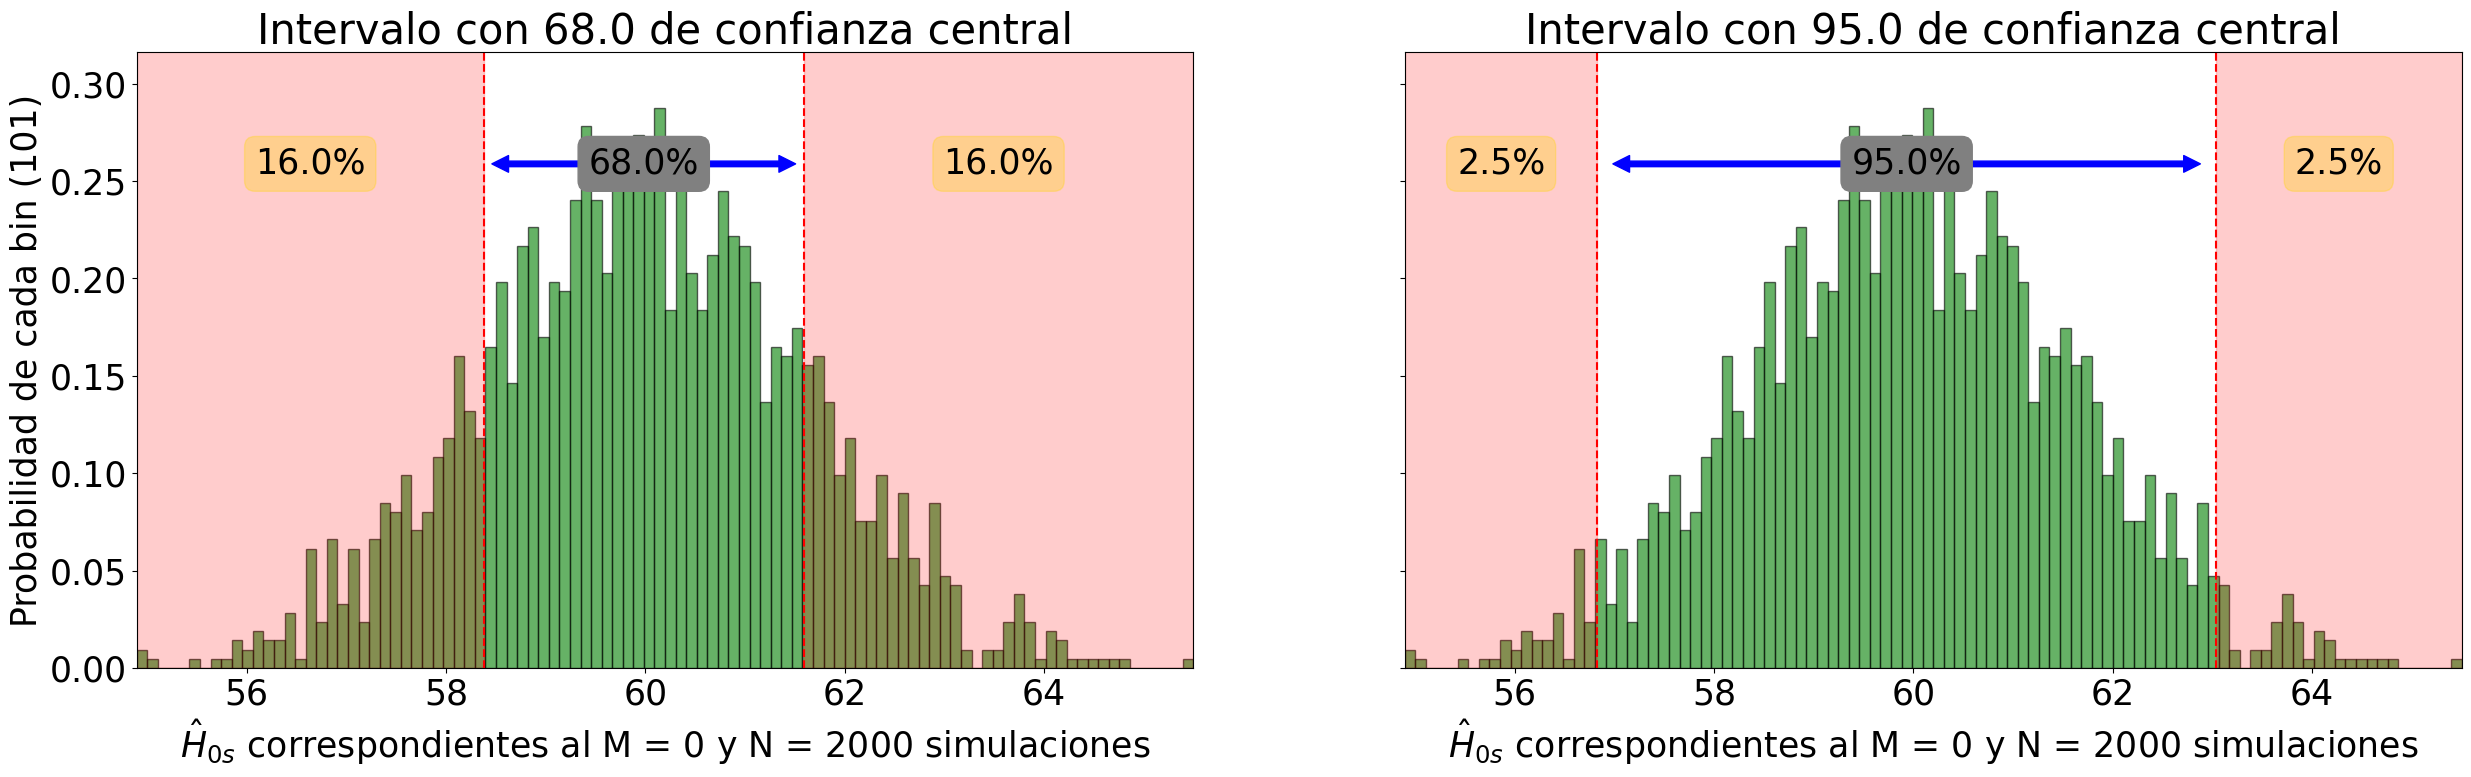

In [148]:
k = 0 # >> Caso que me interesa visualizar

fig, axs = plt.subplots(1, 2, figsize = (30, 8), sharex = False, sharey = True)


#--------------------------------
# Intervalo de confianza para 68%
#--------------------------------
alpha_68 = 68 #%

# Calculo los percentiles para encontrar el intervalo central
H068_min = np.percentile(H0_m[k], (100 - alpha_68)/2)
p_men_H068_min = np.sum(H0_m[k] < H068_min) / len(H0_m[k]) * 100

H068_max = np.percentile(H0_m[k], (100 - alpha_68)/2 + alpha_68)
p_men_H068_max = np.sum(H0_m[k] > H068_max) / len(H0_m[k]) * 100

# ----------------Crafteo el gráfico correspondiente al 68%------------------------
n, bines, _ = axs[0].hist(H0_m[k], bins = 100, edgecolor = 'black', color = 'green', alpha = 0.6, density = True)

axs[0].fill_betweenx([0, 1], min(bines), H068_min, color = 'red', alpha = 0.2)
axs[0].fill_betweenx([0, 1], max(bines), H068_max, color = 'red', alpha = 0.2)

axs[0].axvline(H068_min, linestyle = '--', color = 'red')
axs[0].axvline(H068_max, linestyle = '--', color = 'red')


# Carteles de probabilidad lateral
props = dict(boxstyle = 'round', color = 'gold', alpha = 0.3)


axs[0].text( (min(bines) + H068_min)/2,  max(n) - max(n)*0.1, f'{p_men_H068_min}%',
            bbox = props, verticalalignment='center', horizontalalignment='center')

axs[0].text( (H068_max + max(bines))/2,  max(n) - max(n)*0.1, f'{p_men_H068_max}%',
            bbox = props, verticalalignment='center', horizontalalignment='center')

prob_real = np.sum(np.logical_and(H0_m[k] > H068_min,H0_m[k] < H068_max)) / len(H0_m[k]) * 100
arrowprops = dict(color = 'blue', shrink = 0.05)

# Flechas y cartel central
props = dict(boxstyle = 'round', color = 'gray')
axs[0].annotate('', xy = (H068_min, max(n) - max(n)*0.1), xytext = ((H068_max + H068_min)/2, max(n) - max(n)*0.1),
                arrowprops = arrowprops)
axs[0].annotate('', xy = (H068_max, max(n) - max(n)*0.1), xytext = ((H068_max + H068_min)/2, max(n) - max(n)*0.1),
                arrowprops = arrowprops)
axs[0].text((H068_max + H068_min)/2 ,  max(n) - max(n)*0.1, 
            f'{prob_real}%', bbox = props, verticalalignment='center', horizontalalignment='center')

axs[0].set(xlim = (min(bines), max(bines)), ylim = (0, max(n) + max(n)*0.1), title = f'Intervalo con {prob_real} de confianza central', 
           ylabel = f'Probabilidad de cada bin ({len(bines)})', xlabel = r'$\hat{H}_{0s}$ correspondientes al M = ' + f'{k} y N = {N} simulaciones')

#--------------------------------
# Intervalo de confianza para 95%
#--------------------------------
alpha_95 = 95 #%

# Calculo los percentiles para encontrar el intervalo central
H095_min = np.percentile(H0_m[k], (100 - alpha_95)/2)
p_men_H095_min = np.sum(H0_m[k] < H095_min) / len(H0_m[k]) * 100

H095_max = np.percentile(H0_m[k], (100 - alpha_95)/2 + alpha_95)
p_men_H095_max = np.sum(H0_m[k] > H095_max) / len(H0_m[k]) * 100

# ----------------Crafteo el gráfico correspondiente al 95%------------------------
n, bines, _ = axs[1].hist(H0_m[k], bins = 100, edgecolor = 'black', color = 'green', alpha = 0.6, density = True)

axs[1].fill_betweenx([0, 1], min(bines), H095_min, color = 'red', alpha = 0.2)
axs[1].fill_betweenx([0, 1], max(bines), H095_max, color = 'red', alpha = 0.2)

axs[1].axvline(H095_min, linestyle = '--', color = 'red')
axs[1].axvline(H095_max, linestyle = '--', color = 'red')


# Carteles de probabilidad lateral
props = dict(boxstyle = 'round', color = 'gold', alpha = 0.3)


axs[1].text( (min(bines) + H095_min)/2,  max(n) - max(n)*0.1, f'{p_men_H095_min}%',
            bbox = props, verticalalignment='center', horizontalalignment='center')

axs[1].text( (H095_max + max(bines))/2,  max(n) - max(n)*0.1, f'{p_men_H095_max}%',
            bbox = props, verticalalignment='center', horizontalalignment='center')

prob_real = np.sum(np.logical_and(H0_m[k] > H095_min, H0_m[k] < H095_max)) / len(H0_m[k]) * 100
arrowprops = dict(color = 'blue', shrink = 0.05)

# Flechas y cartel central
props = dict(boxstyle = 'round', color = 'gray')
axs[1].annotate('', xy = (H095_min, max(n) - max(n)*0.1), xytext = ((H095_max + H095_min)/2, max(n) - max(n)*0.1),
                arrowprops = arrowprops)
axs[1].annotate('', xy = (H095_max, max(n) - max(n)*0.1), xytext = ((H095_max + H095_min)/2, max(n) - max(n)*0.1),
                arrowprops = arrowprops)
axs[1].text((H095_max + H095_min)/2 ,  max(n) - max(n)*0.1, 
            f'{prob_real}%', bbox = props, verticalalignment='center', horizontalalignment='center')

axs[1].set(xlim = (min(bines), max(bines)), ylim = (0, max(n) + max(n)*0.1),
           title = f'Intervalo con {prob_real} de confianza central',
           xlabel = r'$\hat{H}_{0s}$ correspondientes al M = ' + f'{k} y N = {N} simulaciones')

plt.rcParams['font.size'] = 25
plt.savefig('imagenes/Item_4.pdf')
plt.savefig('imagenes/Item_4.png')
plt.show()

## Item 5

Repito lo mismo que en el $Item 4$ pero para todos los $M$ y sin gráficos individuales

In [10]:
#--------------------------------
# Intervalo de confianza para 68%
#--------------------------------
H068_mins = [ np.percentile(H0_mi, (100 - alpha_68)/2) for H0_mi in H0_m ]
H068_maxs = [ np.percentile(H0_mi, (100 - alpha_68)/2 + alpha_68) for H0_mi in H0_m ]

#--------------------------------
# Intervalo de confianza para 95%
#--------------------------------
H095_mins = [ np.percentile(H0_mi, (100 - alpha_95)/2) for H0_mi in H0_m ]
H095_maxs = [ np.percentile(H0_mi, (100 - alpha_95)/2 + alpha_95) for H0_mi in H0_m ]

Hago una interpolación en el punto donde se encuentra $H_{0-popt}$ para poder dar un intervalo de confianza de $68 \%$ y $95 \%$

In [11]:
#--------------------------------
# Intervalo de confianza para 68%
#--------------------------------
contacto68_sup = np.interp(H0_popt, H068_mins, H0s)
contacto68_sub = np.interp(H0_popt, H068_maxs, H0s)

#--------------------------------
# Intervalo de confianza para 95%
#--------------------------------
contacto95_sup = np.interp(H0_popt, H095_mins, H0s)
contacto95_sub = np.interp(H0_popt, H095_maxs, H0s)

Gráfico para el informe

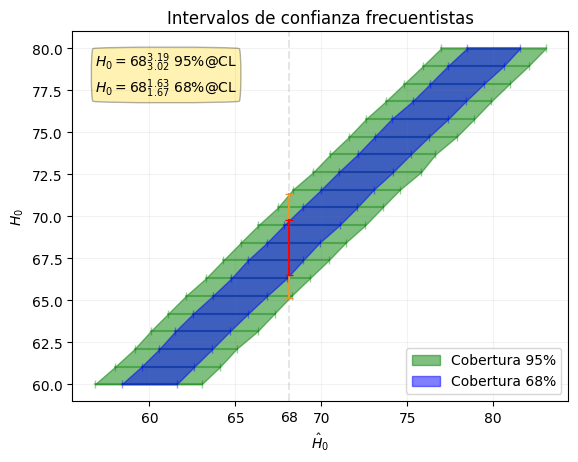

H0_popt = 68.14416703054454
 Intevalos al 68CL: (1.6287100369527678, 1.6676783676956148)
 Intevalos al 95CL: (3.1937877014999003, 3.015509982215576)


In [12]:
fig, axs = plt.subplots(1, 1)
axs.axvline(H0_popt, linestyle = '--', color = 'gray', alpha = 0.2)

#--------------------------------
# Intervalo de confianza para 95%
#--------------------------------
[axs.plot([H095_mins[k], H095_maxs[k]], [h0_real]*2, marker = '|', color = 'green', linestyle = '-', alpha = 0.4) for k, (h0_real) in enumerate(H0s)]
axs.fill_betweenx(H0s, H095_mins, H095_maxs, color = 'green', alpha = 0.5, label = 'Cobertura 95%')

axs.plot(H0_popt, contacto95_sup, marker = '_', color ="#EB972A")
axs.plot([H0_popt]*2, [contacto95_sub, contacto95_sup], linestyle = '-', color = '#EB972A')
axs.plot(H0_popt, contacto95_sub, marker = '_', color ='#EB972A')

#--------------------------------
# Intervalo de confianza para 68%
#--------------------------------
[axs.plot([H068_mins[k], H068_maxs[k]], [h0_real]*2, marker = '|', color = 'blue', linestyle = '-', alpha = 0.4) for k, (h0_real) in enumerate(H0s)]
axs.fill_betweenx(H0s, H068_mins, H068_maxs, color = 'blue', alpha = 0.5, label = 'Cobertura 68%')

axs.plot(H0_popt, contacto68_sup, marker = '_', color ="#FF0000")
axs.plot([H0_popt]*2, [contacto68_sub, contacto68_sup], linestyle = '-', color = '#FF0000')
axs.plot(H0_popt, contacto68_sub, marker = '_', color ='#FF0000')

#--------------------------------
# Cartel con resultados
#--------------------------------
props = {
    'boxstyle': 'Round4',
    'facecolor': 'gold',
    'alpha': 0.3
}
resultado95 = fr'$H_0 = { {round(int(H0_popt), 2)} }^{ {float(round(contacto95_sup - H0_popt, 2))} }_{ {float(round(H0_popt - contacto95_sub, 2))} }$ 95%@CL' + '\n'
resultado68 = fr'$H_0 = { {round(int(H0_popt), 2)} }^{ {float(round(contacto68_sup - H0_popt, 2))} }_{ {float(round(H0_popt - contacto68_sub, 2))} }$ 68%@CL'
axs.text(min(H095_mins), max(H095_mins), resultado95 + resultado68, 
         verticalalignment = 'bottom', horizontalalignment = 'left', bbox = props)

axs.text(H0_popt, min(H0s) - min(H0s)*0.04, rf'${ {int(round(H0_popt, 0))} }$',
         verticalalignment = 'bottom', horizontalalignment = 'center')

#--------------------------------
# Configuraciones del plot
#--------------------------------

axs.set(ylabel = r'$H_0$', xlabel = r'$\hat{H}_0$', title = 'Intervalos de confianza frecuentistas')
axs.legend(loc = 'lower right')
axs.grid(alpha = 0.1, color = 'gray')

plt.savefig('Imagenes/Intevalo_frecuentista.pdf')
plt.savefig('Imagenes/Intevalo_frecuentista.png')
plt.show()

# Reporto el resultado
print(
    f'H0_popt = {H0_popt}\n',
    f'Intevalos al 68CL: ({contacto68_sup - H0_popt}, {H0_popt - contacto68_sub})\n',
    f'Intevalos al 95CL: ({contacto95_sup - H0_popt}, {H0_popt - contacto95_sub})'
)

# Intervalo de credibilidad bayesiano

## Item 1

En este ejercicio me piden "Escribir la expresión de la posterior para $H_0$ (fijando $\Omega_m$), suponiendo errores gaussianos e independientes". Que los errores sean gaussianos e independientes me permite escribir la función de distribución de la siguiente forma:

$$f\left( \vec{x} | \vec{\theta} \right) = \prod_{i = 1}^{N} \frac{1}{ \sqrt{2\pi} \sigma_{H_i} }e^{-\frac{1}{2} \left( \frac{x_i - H\left( z \right)}{\sigma_{H_{zi}}} \right)^2} $$

Donde $H\left(z\right)$ es la expuesta al principio del trabajo. Si utilizamos el Teorema de Bayes:

$$P\left( H_0 | \vec{x} \right) = \frac{ \prod_{i = 1}^{N} \frac{1}{ \sqrt{2\pi} \sigma_{H_i} }e^{-\frac{1}{2} \left( \frac{x_i - H\left( z \right)}{\sigma_{H_{zi}}} \right)^2} \Pi \left(H_0\right)}{Z\left(\vec{x}\right)}$$

Donde:

$$Z\left( \vec{x} \right) = \int f\left( H_0 | \vec{x} \right) \Pi \left( H_0 \right) d\left(H_0\right)$$

Teniendo estas cosas en cuenta me defino una función de python que posea la variable $H_0$ libre y $\Omega_m = 0.3$.

La función que definí me calcula la distribución para cada $H_0$ que le de, teniendo en cuenta los datos tomados. Si le paso un array con muchos valores de $H_0$ lo puedo pensar como que voy realizando un "rastreo" de la función del $Likelihood$ que quiero obtener.

(En el código está escrito todo como si fuese Likelihood porque me confundí en la notación que tuvimos de la clase, no le cambio el nombre porque me da miedo que se rompa todo el código que sigue después)

In [2]:
def Likelihood(H0i, x, y, err_y):
    Li = []
    for xi, yi, err_yi in zip(x, y, err_y):
        Li.append(norm(loc = H_modelo(xi, H0i, Omega_dato), scale = err_yi).pdf(yi))
    return np.prod(Li)

Busco visualizar la función de distribución de todos mis datos

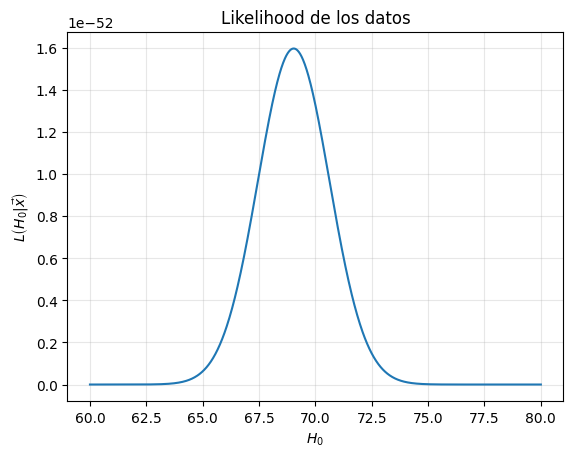

In [8]:
# Lo vuelvo a definir aca así no es necesario correr todo lo anterior
Omega_dato = 0.3
# Defino un array de valores para diferentes puntos de H0
h0s = np.linspace(60, 80, 1_000)
L = [Likelihood(h, z_datos, Hz_datos, err_Hz_datos) for h in h0s]

# -------> Gráfico de los datos <--------------
fig, axs = plt.subplots(1, 1)

axs.plot(h0s, L, '-')
axs.set(xlabel = r'$H_0$', ylabel = r'$L\left(H_0 | \vec{x}\right)$',
        title = 'Likelihood de los datos')
axs.grid(alpha = 0.3)

plt.savefig('Imagenes/Likelihood_datos.png')
plt.savefig('Imagenes/Likelihood_datos.pdf')
plt.show()

## Item 2

Construyo las funciones de distribución utilizando la lógica mencionada en el primer item. En ambos casos hago un abuso de conocer donde se encuentra el mayor aporde de las funciones de distribución multiplicadas, así $quad$ puede realizar correctamente la integral.

In [9]:
#------------------------
# Prior uniforme[60, 80]
#------------------------
# Numerador de Bayes
def L_prior_unif(H0, x, y, err_y): return Likelihood(H0, x, y, err_y) * uniform(loc = 60, scale = 20).pdf(H0)

# Calculo la evidencia (Abuso que fuera de los valores de 60 y 80 el prior es nulo)
Z_unif = quad(L_prior_unif, 60, 80, args = (z_datos, Hz_datos, err_Hz_datos))[0] # >> Acá es donde se ve que Z depende solo de mis mediciones, la dependencia con H0 se va en integrar

def L_H0_unif(H0, x, y, err_y): return float(L_prior_unif(H0, x, y, err_y) / Z_unif)

#------------------------
# Prior gaussiana[70, 5]
#------------------------
# Numerador de Bayes
def L_prior_gaus(H0, x, y, err_y): return Likelihood(H0, x, y, err_y) * norm(loc = 70, scale = 5).pdf(H0)

# Calculo la evidencia (Viendo la distribución L_prior_gaus abuso que cae muy rapido en 60 y 80)
Z_gaus = quad(L_prior_gaus, 60, 80, args = (z_datos, Hz_datos, err_Hz_datos))[0] # >> Acá es donde se ve que Z depende solo de mis mediciones, la dependencia con H0 se va en integrar

def L_H0_gaus(H0, x, y, err_y): return float(L_prior_gaus(H0, x, y, err_y) / Z_gaus)


Creo la lista de valores para poder visualizar las funciones de distribución

In [10]:
# Defino una lista de H0s
h0s_valores = np.linspace(62, 75, 1_000)

# Me creo un array en los H0s anteriores para poder ver la distribución
Lh0_unif = np.array([L_H0_unif(j, z_datos, Hz_datos, err_Hz_datos) for j in h0s_valores])
Lh0_gaus = np.array([L_H0_gaus(j, z_datos, Hz_datos, err_Hz_datos) for j in h0s_valores])

# Saco los valores intermedios
h0med_gaus = np.trapezoid(h0s_valores * Lh0_gaus, h0s_valores)
h0med_unif = np.trapezoid(h0s_valores * Lh0_unif, h0s_valores)

Defino una función para poder obtener directamente de la forma de la función de distribución (y no de realizaciones de esa misma distribución) el percentile, integrando y acumulando índices hasta llegar a la probabilidad pedida.

Además calculo los percentiles para ambos $posteriors$ y para ambos intervalos de confianza. Finalmente también calculo la esperanza de cada distribución

In [11]:
# ------> Defino la función para percentiles <---------------
def percentile(y, x, P):
    k = 0
    while True:
        prob = np.trapezoid(y[:k], x[:k])
        if prob >= P:
            break
        else:
            k += 1
    return k

#------------------------------
# Percentiles de confianza 68%
#------------------------------
alpha68 = 0.68

# -----> Prior de gauss
P_izq_gaus68 = percentile(Lh0_gaus, h0s_valores, (1 - alpha68)/2)
P_der_gaus68 = percentile(Lh0_gaus, h0s_valores, (1 - alpha68)/2 + alpha68)

# -----> Prior de uniforme
P_izq_unif68 = percentile(Lh0_unif, h0s_valores, (1 - alpha68)/2)
P_der_unif68 = percentile(Lh0_unif, h0s_valores, (1 - alpha68)/2 + alpha68)

#------------------------------
# Percentiles de confianza 95%
#------------------------------
alpha95 = 0.95

# -----> Prior de gauss
P_izq_gaus95 = percentile(Lh0_gaus, h0s_valores, (1 - alpha95)/2)
P_der_gaus95 = percentile(Lh0_gaus, h0s_valores, (1 - alpha95)/2 + alpha95)

# -----> Prior de uniforme
P_izq_unif95 = percentile(Lh0_unif, h0s_valores, (1 - alpha95)/2)
P_der_unif95 = percentile(Lh0_unif, h0s_valores, (1 - alpha95)/2 + alpha95)

#---------------------------------
# Esperanzas de las distribuciones
#---------------------------------
E_unif = np.trapezoid(Lh0_unif*h0s_valores, h0s_valores)
E_gaus = np.trapezoid(Lh0_gaus*h0s_valores, h0s_valores)


Saco los gráficos

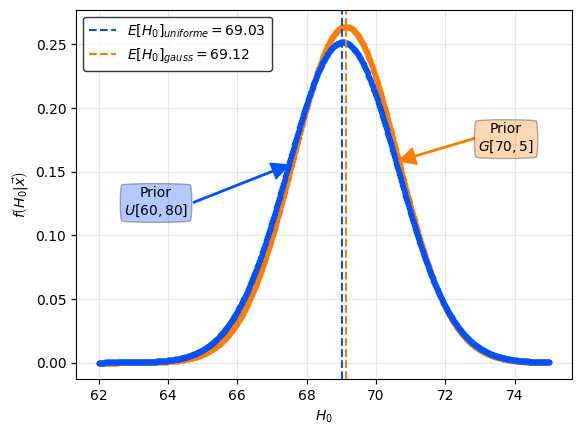

In [12]:
fig, axs = plt.subplots(1, 1, sharey = True)

axs.plot(h0s_valores, Lh0_gaus, '.', color = "#FF7C02")
axs.plot(h0s_valores, Lh0_unif, '.', color = "#0051FF")

axs.axvline(E_unif, linestyle = '--', color = '#0051FF', label = r'$E\left[H_0\right]_{uniforme} = $' + f'{np.round(E_unif, 2)}')
axs.axvline(E_gaus, linestyle = '--', color = '#FF7C02', label = r'$E\left[H_0\right]_{gauss} = $' + f'{np.round(E_gaus, 2)}')

axs.set(xlabel = r'$H_0$', ylabel = r'$f\left(H_0 | \vec{x}\right)$')

arrowprops_uni = {
    'color': '#0051FF',
    'width': 1
}
bbox_unif = {
    'boxstyle': 'Round4',
    'color': '#0051FF',
    'linestyle': '-',
    'ec': 'black',
    'alpha': 0.3
}

texto_prior_uniforme = 'Prior\n' + r'$U\left[60, 80\right]$'
axs.annotate('', xy = (h0s_valores[P_izq_unif68], Lh0_unif[P_izq_unif68]), xytext = ((h0s_valores[P_izq_unif68] + min(h0s_valores))/2, max(Lh0_unif)/2), 
             arrowprops = arrowprops_uni)
axs.text((h0s_valores[P_izq_unif68] + min(h0s_valores))/2.034, max(Lh0_unif)/2, texto_prior_uniforme, 
         bbox = bbox_unif, verticalalignment = 'center', horizontalalignment = 'center')

arrowprops_gaus = {
    'color': '#FF7C02',
    'width': 1
}
bbox_gaus = {
    'boxstyle': 'Round4',
    'color': '#FF7C02',
    'linestyle': '-',
    'ec': 'black',
    'alpha': 0.3
}

texto_prior_gaus = 'Prior\n' + r'$G\left[70, 5\right]$'
axs.annotate('', xy = (h0s_valores[P_der_gaus68], Lh0_gaus[P_der_gaus68]), xytext = ((h0s_valores[P_der_gaus68] + max(h0s_valores))/2, max(Lh0_gaus)/1.5), 
             arrowprops = arrowprops_gaus)
axs.text((h0s_valores[P_der_gaus68] + max(h0s_valores))/1.975, max(Lh0_gaus)/1.5, texto_prior_gaus, 
         bbox = bbox_gaus, verticalalignment = 'center', horizontalalignment = 'center')

axs.grid(alpha = 0.3)
axs.legend(loc = 'upper left', edgecolor = 'black')

plt.savefig('Imagenes/Bayes_graficos.png')
plt.savefig('Imagenes/Bayes_graficos.pdf')
plt.show()

In [266]:
print(E_unif, E_unif - h0s_valores[P_izq_unif68], E_unif - h0s_valores[P_der_unif68])
print(E_unif, E_unif - h0s_valores[P_izq_unif95], E_unif - h0s_valores[P_der_unif95])

print(E_gaus, E_gaus - h0s_valores[P_izq_unif68], E_gaus - h0s_valores[P_der_unif68])
print(E_gaus, E_gaus - h0s_valores[P_izq_unif95], E_gaus - h0s_valores[P_der_unif95])

69.03061128471654 1.5521328062380633 -1.6100293559240981
69.03061128471654 3.0876683417735933 -3.1325518784466198
69.12144078259197 1.642962304113496 -1.5191998580486654
69.12144078259197 3.178497839649026 -3.041722380571187
